In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#Generates numpy array with values from 0 to 2pi with a step of .005
theta = np.arange(0, 2*np.pi, .005, dtype = float)
num_points = len(theta)
r1, r2 = 2, 4

np.random.seed(1) #Set seed for replicability
#Generates x and y values for two circles using polar coordinates
# x = radius * cos(theta) + random noise; y = radius * sin(theta) + random noise
# .4 was arbitrarily chosen as the standard deviation to have some points in the circles overlap
x, y = r1 * np.cos(theta) + np.random.normal(0, .4, len(theta)), r1 * np.sin(theta) + np.random.normal(0, .4, num_points)
x2, y2 = r2 * np.cos(theta) + np.random.normal(0, .4, len(theta)), r2 * np.sin(theta) + np.random.normal(0, .4, num_points)

x_vals = np.concatenate((x,x2), axis = None)
y_vals = np.concatenate((y,y2), axis = None)
#Use np.stack to pair coordinates as predictors X
X = np.stack((x_vals, y_vals), axis = 1)

#Define labels as Y
Y = np.concatenate((np.zeros(num_points), np.ones(num_points)), axis = None)

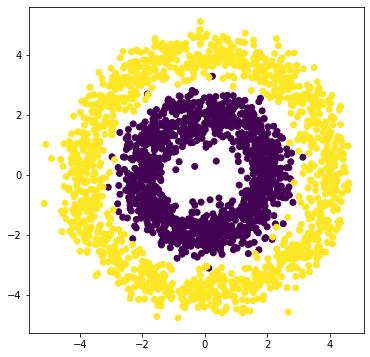

In [3]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)
plt.scatter(X.T[0,], X.T[1,], c = Y)
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
X_train = X_train.T 
X_test  = X_test.T 
Y_train = Y_train.reshape(1, Y_train.shape[0])
Y_test  = Y_test.reshape(1, Y_test.shape[0])

In [5]:
X_train.shape, Y_train.shape

((2, 1885), (1, 1885))

The following is a modified, annotated version of Dr. Shahina Rahman's code used in a Deep Learning Lecture for STAT 421 at Texas A&M University (https://anniemux.wixsite.com/mysite-2) 

In [6]:
def initialize_params(n_i, n_h, n_y):
    """
    Arguments:
    n_i: nodes in input layer (2: x and y coordinates)
    n_h: nodes in hidden layer (going to arbitrarily chose 4 for our network)
    n_y: nodes in output layer (1 response variable with 2 outcomes: 0 or 1)
    
    Returns:
    params: dictionary containing initial parameters of network
        W1 - weight matrix of shape n_h by n_i (4 x 2)
        b1 - bias vector of shape n_h by 1 (4 x 1)
        W2 - weight matrix of shape n_y by n_h (1 x 4)
        b2 - bias vector of shape n_y by 1 (1 x 1)
    """

    np.random.seed(2)  #Set seed for replicability
    
    #np.random.randn returns a matrix of values generated from a standard normal distribution
    W1 = np.random.randn(n_h, n_i)
    b1 = np.zeros(shape = (n_h,1))
    W2 = np.random.randn(n_y, n_h)
    b2 = np.zeros(shape = (n_y,1))
    
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return params

In [7]:
def forward_propagation(X, parameters):
    """
    Argument:
    X: input data of size (n_i, m); training data
    parameters: dictionary containing NN parameters (output of initialize_params function)
    
    Returns:
    A2: The sigmoid output of the second activation
    cache: dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    #In this case our training data X could also be notated as A0, the naming convention for the input layer
    
    Z1 = np.dot(W1, X) + b1    # Z1 = W1A1 + W2A2 + ... + WnAn + b
    #Using tanh as our activation function for hidden layer
    A1 = np.tanh(Z1) #returns matrix of values between -1 and 1
    Z2 = np.dot(W2, A1) + b2 
    #Using sigmoid as activation function for hidden layer
    A2 = 1/(1+ np.exp(-Z2)) #returns matrix of values between 0 and 1
    
    #Cache our activation functions and values for backward propagation
    cache = {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2}
    
    return A2, cache

In [8]:
def compute_cost(A2, Y, parameters):
    """
    Arguments:
    A2: The sigmoid output of the second activation - of shape (1, number of examples)
    Y: "true" labels vector of shape (1, number of observations)
    parameters: dictionary containing parameters W1, b1, W2 and b2
    
    Returns:
    cost: cross-entropy cost given for classification
    """
    
    m = Y.shape[1] # number of observations
    
    #https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
    logprobs = np.multiply(np.log(A2), Y) +  np.multiply(np.log(1 - A2), (1 - Y)) # Compute the log probabilities of cross-entropy cost
    #Average cost of all training data
    cost = - np.sum(logprobs) / m
    
    return cost

In [9]:
def backward_propagation(parameters, cache, X, Y):
    """
    Arguments:
    parameters: dictionary containing our parameters 
    cache: dictionary containing "Z1", "A1", "Z2" and "A2".
    X: input data of shape (2, number of examples)
    Y: "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- dictionary containing gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve weights from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # Retrieve also activation functions from dictionary "cache". 
    A1 = cache['A1']
    A2 = cache['A2']

    # Z1 = np.dot(W1, X) + b1 
    # Z2 partial derivative of W1, dZ2/dW1 = (dZ2/dW2)*(dW2/dZ1)*(dZ1/dW1)= (dZ2/dW2)*( dW2/dZ1) * XT  
    # A1 = np.tanh(Z1) 
    # Z2 is partial derivative of Z1, dZ2/dZ1 = (dZ2/dW2)*(dW2/dZ1) = (dZ2/dW2) * dTanh = (dZ2/dW2) * (1- np.power(A1, 2))  
    # Z2 = np.dot(W2, A1) + b2 
    # Z2 partial derivative of W2, dZ2/dW2 = dZ2 * A1.T  
    # A2 = sigmoid(Z2)   
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1,"dW2": dW2,"db2": db2}
    
    return grads

In [10]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Arguments:
    parameters: dictionary containing parameters 
    grads: dictionary containing gradients 
    
    Returns:
    parameters: dictionary containing updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    # Update rule for each parameter
    # We use direction and magnitude of parameter gradients to tune our weights and biases
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,"b1": b1,"W2": W2,"b2": b2}
    
    return parameters

In [11]:
def nn_model(X, Y, n_h, num_iterations=10001, print_cost=False):
    """
    Arguments:
    X: dataset of shape (2, number of examples)
    Y: labels of shape (1, number of examples)
    n_h: nodes in hidden layer
    num_iterations: Number of iterations in gradient descent loop
    print_cost: if True, print the cost every 1000 iterations
    
    Returns:
    parameters: parameters learned by the model. They can then be used to predict.
    """
    
    np.random.seed(3) #Set seed for replicability
    #define n_i and n_y to make sure they match shapes of input
    n_i = X.shape[0]
    n_y = Y.shape[0]
    
    # Initialize parameters
    parameters = initialize_params(n_i, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters) #computes current loss with this iteration of weights and biases
        grads = backward_propagation(parameters, cache, X, Y) #calculate current gradient of weights and biases
        parameters = update_parameters(parameters, grads) #reassign new values of parameters 

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" % (i, cost)) 
    
    return parameters

In [12]:
def predict(parameters, X):
    """
    Arguments:
    parameters: dictionary containing your parameters 
    X: input data of size (n_i, m)
    
    Returns
    predictions: vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
        
    # 0 if A2 < .5, 1 if A2 >=.5
    predictions = np.round(A2) #Classifies based on output of A2 sigmoid function
    
    return predictions

In [13]:
parameters = nn_model(X_train, Y_train, 4, print_cost = True) #Notice how the cost reduces 10-fold after 1000 iterations

Cost after iteration 0: 1.522690
Cost after iteration 1000: 0.096707
Cost after iteration 2000: 0.082765
Cost after iteration 3000: 0.080749
Cost after iteration 4000: 0.080702
Cost after iteration 5000: 0.068499
Cost after iteration 6000: 0.080388
Cost after iteration 7000: 0.244165
Cost after iteration 8000: 0.080374
Cost after iteration 9000: 0.066262
Cost after iteration 10000: 0.074003


In [14]:
parameters #Final parameters of the model

{'W1': array([[-1.16689681, -1.28895393],
        [-0.68749617,  2.56433731],
        [-1.55503501,  0.66887221],
        [ 0.33402642, -1.6793105 ]]),
 'b1': array([[ 3.26682345],
        [ 2.30227411],
        [-3.20078238],
        [-4.73322132]]),
 'W2': array([[-11.82556633,  -8.62918128,  11.94538202,   5.00592747]]),
 'b2': array([[16.35054131]])}

In [15]:
accuracy = float((np.dot(Y_test,predict(parameters, X_test).T) + np.dot(1-Y_test,1-predict(parameters, X_test).T))/float(Y_test.size)*100)
print(accuracy) #Our NN was 95.23% accurate!

96.18441971383149


In [16]:
x = X_test[0][(Y_test != predict(parameters, X_test))[0]]
y = X_test[1][(Y_test != predict(parameters, X_test))[0]]
incorrect = np.stack((x,y))

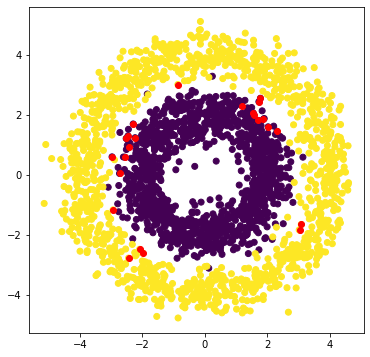

In [17]:
# This plot shows the coordinates of incorrect classifications
# These values are on the edge of boundary between the two classes, meaning that even a human may have trouble classifying these two points.
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)
plt.scatter(X.T[0,], X.T[1,], c = Y)
plt.scatter(incorrect[0,],incorrect[1,], color = 'red')
plt.show()